## Homework


The goal of this homework is to create a classification model to determine whether the customer will subscribe to a term deposit or not (column `'y'`).


### Setup

In [1]:
import sys
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn as skl
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split


print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {skl.__version__}")
print("Setup Complete")

Python version: 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:17:14) [MSC v.1941 64 bit (AMD64)]
NumPy version: 2.1.2
Pandas version: 2.2.3
Scikit-learn version: 1.5.2
Setup Complete



### Dataset

In this homework, we will use the Bank Marketing dataset. Download it from: https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

We need to take `bank/bank-full.csv` file from the downloaded zip-file.  
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not. 

In [2]:
def get_bank_marketing_data(url, inner_zip_name, csv_name): 
    """
    Downloads a nested zip file from a URL and reads a CSV file from it into a pandas DataFrame.

    Parameters:
    url (str): The URL of the outer zip file.
    inner_zip_name (str): The name of the inner zip file inside the outer zip file.
    csv_name (str): The name of the CSV file inside the inner zip file.

    Returns:
    pd.DataFrame: DataFrame containing the data from the CSV file.
    """
    # Download the outer zip file
    response = requests.get(url)
    outer_zip_bytes = BytesIO(response.content)

    # Open the outer zip file
    with zipfile.ZipFile(outer_zip_bytes, 'r') as outer_zip:
        # Read the inner zip file as a file in memory
        with outer_zip.open(inner_zip_name) as inner_zip_file:
            with zipfile.ZipFile(BytesIO(inner_zip_file.read()), 'r') as inner_zip:
                # Read the CSV file directly into a pandas DataFrame
                with inner_zip.open(csv_name) as csv_file:
                    df = pd.read_csv(csv_file, sep=';')
    
    return df


In [3]:
# URL of the external .zip file
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
inner_zip_name = 'bank.zip'
csv_name = 'bank-full.csv'


In [4]:
# Get the data and display the first few rows
df = get_bank_marketing_data(url, inner_zip_name, csv_name)
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Features

For the rest of the homework, you'll need to use only these columns:


In [6]:
features = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y",
]


### Data preparation

* Select only the features from above.

In [7]:
df = df[features]
df.columns


Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

* Check if the missing values are presented in the features.

In [8]:
df.isna().sum()


age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
numerical_features = df.select_dtypes(include=['int64']).columns
numerical_features = numerical_features.tolist()

* Now we want to encode the `y` variable. Let's replace the values `yes`/`no` with `1`/`0`.


In [10]:
df.y = (df.y == 'yes').astype(int)
df.y.value_counts()


y
0    39922
1     5289
Name: count, dtype: int64

In [11]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
categorical_features = categorical_features.tolist()

In [12]:
columns = numerical_features + categorical_features
columns

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'housing',
 'contact',
 'month',
 'poutcome']

- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [13]:
def split_data(df, test_size=0.2, val_size=0.25, random_state=42):

    """
    Split the data into train, validation, and test sets.
    
    Args:
    df (pd.DataFrame): The input dataframe
    test_size (float): Proportion of data to be used for testing
    val_size (float): Proportion of training data to be used for validation
    random_state (int): Seed for random number generator
    
    Returns:
    tuple: (df_train, df_val, df_test, y_train, y_val, y_test)
    """
    # Split into train+val and test
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split train+val into train and val
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset indices
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Extract target variable
    y_train = df_train.pop('y').values
    y_val = df_val.pop('y').values
    y_test = df_test.pop('y').values
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test


In [14]:
# Split the data with random_state=1
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df, random_state=1)

# Print sizes of resulting datasets
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


Train set size: 27126
Validation set size: 9042
Test set size: 9043


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`


In [15]:
# Diccionario para almacenar los resultados
auc_scores = {}

# Calcular AUC para cada variable numérica
for col in numerical_features:
    # Calcular AUC inicial
    auc = roc_auc_score(y_train, df_train[col])
    
    # Si AUC < 0.5, invertir la variable y recalcular
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
        auc_scores[f"-{col}"] = auc
    else:
        auc_scores[col] = auc

# Ordenar los resultados por valor de AUC descendente
sorted_auc = dict(sorted(auc_scores.items(), key=lambda x: x[1], reverse=True))

# Imprimir resultados formateados
print("\nROC AUC scores for numerical features:")
print("=====================================")
for feature, auc in sorted_auc.items():
    print(f"{feature:15} AUC: {auc:.4f}")


ROC AUC scores for numerical features:
duration        AUC: 0.8147
previous        AUC: 0.5986
pdays           AUC: 0.5901
balance         AUC: 0.5888
-campaign       AUC: 0.5715
-day            AUC: 0.5260
-age            AUC: 0.5122


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99


In [16]:
def prepare_features(df_train, df_val):
    """
    Prepare feature matrices for training and validation data.
    
    Args:
    df_train (pd.DataFrame): Training dataframe
    df_val (pd.DataFrame): Validation dataframe
    
    Returns:
    tuple: X_train, X_val
    """
    dv = DictVectorizer(sparse=False)
    
    # Prepare training data
    train_dict = df_train[columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    # Prepare validation data
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    return X_train, X_val


In [17]:
def train_model(X, y, C=1.0):
    """
    Train a logistic regression model.

    Args:
    X (array-like): Feature matrix
    y (array-like): Target vector
    C (float): Regularization parameter

    Returns:
    LogisticRegression: Trained model
    """
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)
    return model


In [18]:
def predict(model, X):
    """
    Make probability predictions using the trained model.

    Args:
    model: Trained model with predict_proba method
    X (array-like): Feature matrix to make predictions on

    Returns:
    np.array: Array of probability predictions for the positive class
    """
    probabilities = model.predict_proba(X)
    y_pred = np.asarray(probabilities[:, 1])
    return y_pred

In [19]:
# Prepare data
X_train, X_val = prepare_features(df_train, df_val)

# Train the model
model = train_model(X_train, y_train)

# Make predictions
val_predictions = predict(model, X_val)

# Calculate ROC AUC score
auc_score = roc_auc_score(y_val, val_predictions)

print(f"ROC AUC on validation set: {auc_score:.3f}")


ROC AUC on validation set: 0.900


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865


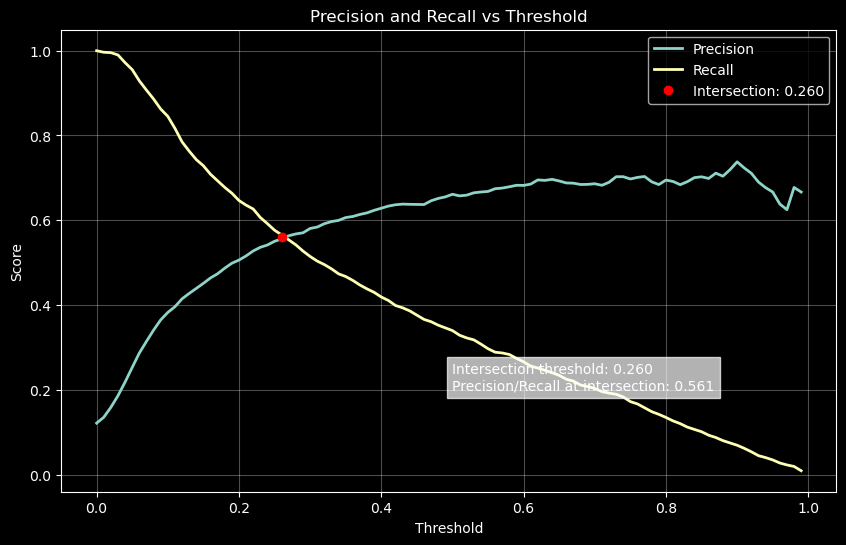


Precise intersection values:
Threshold: 0.260
Precision: 0.556
Recall: 0.566


In [20]:
# Generate threshold values from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0, 1.0, 0.01)

# Lists to store precision and recall values for each threshold
precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred = (val_predictions >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# Convert to numpy arrays for easier manipulation
precisions = np.array(precisions)
recalls = np.array(recalls)

# Find intersection point
# Calculate differences between precision and recall
differences = precisions - recalls
# Find where the difference changes sign (crosses zero)
# We use [:-1] to avoid the endpoint where both curves go to zero
sign_changes = np.where(np.diff(np.signbit(differences[:-1])))[0]

# Get the intersection index
if len(sign_changes) > 0:
    intersection_idx = sign_changes[0]  # Take the first intersection
    intersection_threshold = thresholds[intersection_idx]
    intersection_value = (precisions[intersection_idx] + recalls[intersection_idx]) / 2
else:
    intersection_idx = 0
    intersection_threshold = 0
    intersection_value = 0

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)

# Add intersection point
plt.plot(intersection_threshold, intersection_value, 'ro', 
         label=f'Intersection: {intersection_threshold:.3f}')

# Customize the plot
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add text annotation with intersection point
plt.text(0.5, 0.2, 
         f'Intersection threshold: {intersection_threshold:.3f}\n' +
         f'Precision/Recall at intersection: {intersection_value:.3f}',
         bbox=dict(facecolor='white', alpha=0.7))

plt.show()

print(f"\nPrecise intersection values:")
print(f"Threshold: {intersection_threshold:.3f}")
print(f"Precision: {precisions[intersection_idx]:.3f}")
print(f"Recall: {recalls[intersection_idx]:.3f}")

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


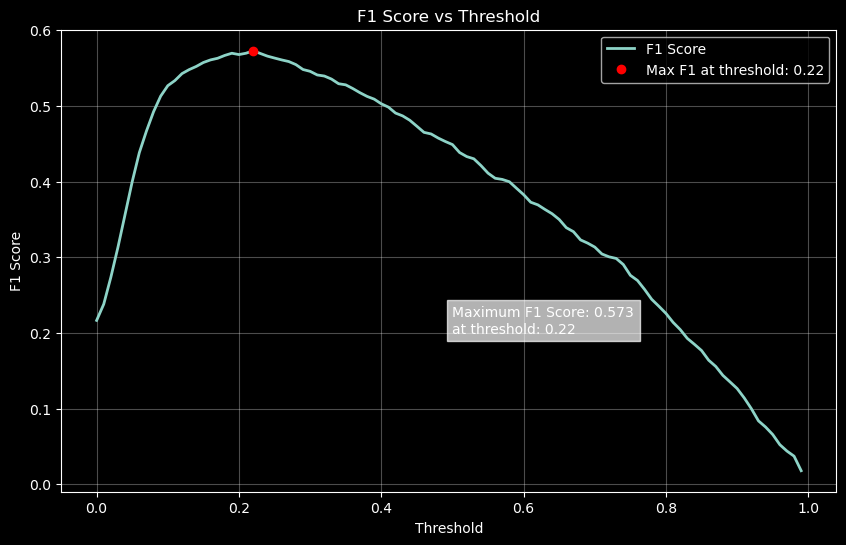


F1 Score Analysis Results:
Maximum F1 Score: 0.573
Optimal Threshold: 0.22


In [21]:
# Lists to store f1 values for each threshold
f1_scores = []

# Calculate metrics for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred = (val_predictions >= threshold).astype(int)
    
    # Calculate f1 score directly using sklearn
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# Convert to numpy array
f1_scores = np.array(f1_scores)

# Find the threshold that maximizes F1
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)

# Add point of maximum F1
plt.plot(max_f1_threshold, max_f1_score, 'ro', 
         label=f'Max F1 at threshold: {max_f1_threshold:.2f}')

# Customize the plot
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add text annotation with maximum point
plt.text(0.5, 0.2, 
         f'Maximum F1 Score: {max_f1_score:.3f}\n' +
         f'at threshold: {max_f1_threshold:.2f}',
         bbox=dict(facecolor='white', alpha=0.7))

plt.show()

print(f"\nF1 Score Analysis Results:")
print(f"Maximum F1 Score: {max_f1_score:.3f}")
print(f"Optimal Threshold: {max_f1_threshold:.2f}")

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26


In [22]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store AUC scores for each fold
fold_scores = []

# Convert dataframe to list of dictionaries (needed for DictVectorizer)
train_dicts = df_full_train[columns].to_dict(orient='records')

# Get target variable
y_full = df_full_train['y'].values

# Perform k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dicts), 1):
    # Split data for this fold
    train_dicts_fold = [train_dicts[i] for i in train_idx]
    val_dicts_fold = [train_dicts[i] for i in val_idx]
    
    y_train_fold = y_full[train_idx]
    y_val_fold = y_full[val_idx]
    
    # Initialize and fit DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dicts_fold)
    X_val_fold = dv.transform(val_dicts_fold)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    val_predictions = model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate and store AUC score
    auc_score = roc_auc_score(y_val_fold, val_predictions)
    fold_scores.append(auc_score)
    
    print(f"Fold {fold} AUC: {auc_score:.3f}")

# Calculate statistics
mean_auc = np.mean(fold_scores)
std_auc = np.std(fold_scores)

print("\nCross-validation results:")
print("========================")
print(f"Individual fold scores: {[f'{score:.3f}' for score in fold_scores]}")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Standard Deviation: {std_auc:.3f}")

Fold 1 AUC: 0.899
Fold 2 AUC: 0.899
Fold 3 AUC: 0.911
Fold 4 AUC: 0.908
Fold 5 AUC: 0.911

Cross-validation results:
Individual fold scores: ['0.899', '0.899', '0.911', '0.908', '0.911']
Mean AUC: 0.906
Standard Deviation: 0.005


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [23]:
# Initialize parameters
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results for each C value
results = {}

# Convert dataframe to list of dictionaries
train_dicts = df_full_train[columns].to_dict(orient='records')
y_full = df_full_train['y'].values

# Iterate over C values
for C in C_values:
    fold_scores = []
    
    # Perform k-fold cross validation for this C value
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dicts), 1):
        # Split data for this fold
        train_dicts_fold = [train_dicts[i] for i in train_idx]
        val_dicts_fold = [train_dicts[i] for i in val_idx]
        
        y_train_fold = y_full[train_idx]
        y_val_fold = y_full[val_idx]
        
        # Initialize and fit DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dicts_fold)
        X_val_fold = dv.transform(val_dicts_fold)
        
        # Train model with current C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        val_predictions = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate and store AUC score
        auc_score = roc_auc_score(y_val_fold, val_predictions)
        fold_scores.append(auc_score)
    
    # Calculate mean and std for this C value
    mean_auc = np.mean(fold_scores)
    std_auc = np.std(fold_scores)
    
    # Store results
    results[C] = {
        'mean_auc': round(mean_auc, 3),
        'std_auc': round(std_auc, 3),
        'fold_scores': fold_scores
    }

# Print results in a formatted way
print("Cross-validation results for different C values:")
print("=============================================")
for C in C_values:
    print(f"\nC = {C}")
    print(f"Mean AUC: {results[C]['mean_auc']:.3f}")
    print(f"Std AUC:  {results[C]['std_auc']:.3f}")
    print(f"Individual fold scores: {[f'{score:.3f}' for score in results[C]['fold_scores']]}")

# Find best C value considering mean and std
best_C = C_values[0]
best_mean = results[best_C]['mean_auc']
best_std = results[best_C]['std_auc']

for C in C_values[1:]:
    current_mean = results[C]['mean_auc']
    current_std = results[C]['std_auc']
    
    # Update best if:
    # 1. Current mean is higher
    # 2. Current mean is equal but std is lower
    if (current_mean > best_mean) or \
       (current_mean == best_mean and current_std < best_std):
        best_C = C
        best_mean = current_mean
        best_std = current_std

print("\nBest parameters:")
print(f"C = {best_C}")
print(f"Mean AUC = {best_mean:.3f}")
print(f"Std AUC = {best_std:.3f}")

Cross-validation results for different C values:

C = 1e-06
Mean AUC: 0.701
Std AUC:  0.009
Individual fold scores: ['0.685', '0.700', '0.712', '0.709', '0.702']

C = 0.001
Mean AUC: 0.861
Std AUC:  0.007
Individual fold scores: ['0.848', '0.860', '0.864', '0.869', '0.865']

C = 1
Mean AUC: 0.906
Std AUC:  0.005
Individual fold scores: ['0.899', '0.899', '0.911', '0.908', '0.911']

Best parameters:
C = 1
Mean AUC = 0.906
Std AUC = 0.005


## Reference

-   Original homework: 
    https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2024/04-evaluation/homework.md